<a href="https://colab.research.google.com/github/Eswa2020/team2_dcs6_loan_prediction/blob/main/Copy_of_Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color=”green”> Importing libraries </font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## <font color=”green”> Loading dataset </font>

In [4]:
loans = pd.read_csv('/content/train_dataset.csv')
# test = pd.read_csv('test_dataset.csv')

## <font color=”green”>Exploring our Dataset  </font>

In [81]:
loans.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [82]:
loans.tail()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
164304,10164305,"20,725",10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,16,Male,2
164305,10164306,"6,000",8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,30,Male,2
164306,10164307,"20,250",10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,30,Male,1
164307,10164308,"10,000",4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,62,Female,3
164308,10164309,"9,250",10+ years,Rent,NaN,VERIFIED - income,credit_card,19.44,1,NaN,5,9,Female,2


In [89]:
loans.shape

(164309, 14)

In [90]:
loans.duplicated().sum()

0

> no duplicate values

In [91]:
loans.isna().sum()

Loan_ID                        0
Loan_Amount_Requested          0
Length_Employed             7371
Home_Owner                 25349
Annual_Income              25102
Income_Verified                0
Purpose_Of_Loan                0
Debt_To_Income                 0
Inquiries_Last_6Mo             0
Months_Since_Deliquency    88379
Number_Open_Accounts           0
Total_Accounts                 0
Gender                         0
Interest_Rate                  0
dtype: int64

> There is a lot of null values in the dataset but cannot be dropped.

* Length employed <- Some borrowers may have not been previously employed, thats why there are null values
* Home owner <- Others can be living with family and friends.
* Annual Income <- Some borrowers may have not been previously employed or some may not have a ligitimate source of income or 😅 they are politicians ... etc
* Months since deliquency <-  In a financial sense, delinquency occurs as soon as a borrower misses a payment on a loan. In contrast, default occurs when a borrower fails to repay the loan as specified in the original contract

In [92]:
loans.dtypes

Loan_ID                      int64
Loan_Amount_Requested       object
Length_Employed             object
Home_Owner                  object
Annual_Income              float64
Income_Verified             object
Purpose_Of_Loan             object
Debt_To_Income             float64
Inquiries_Last_6Mo           int64
Months_Since_Deliquency    float64
Number_Open_Accounts         int64
Total_Accounts               int64
Gender                      object
Interest_Rate                int64
dtype: object

> our datatypes is comprised of both intergers and strings

#### Checking for Outliers

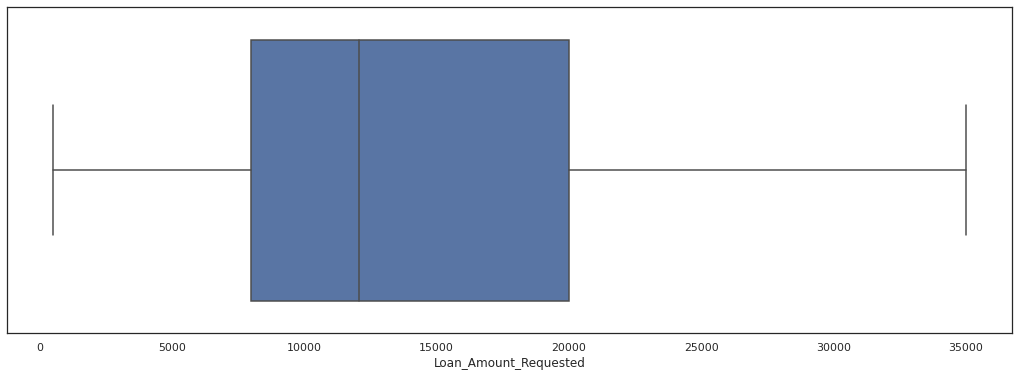

In [110]:
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.boxplot(x=loans['Loan_Amount_Requested'])

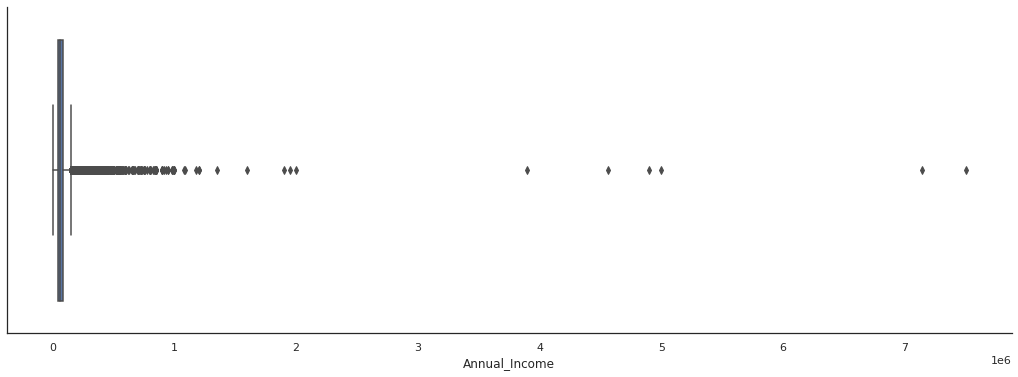

In [94]:
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.boxplot(x=loans['Annual_Income'])
sns.despine()

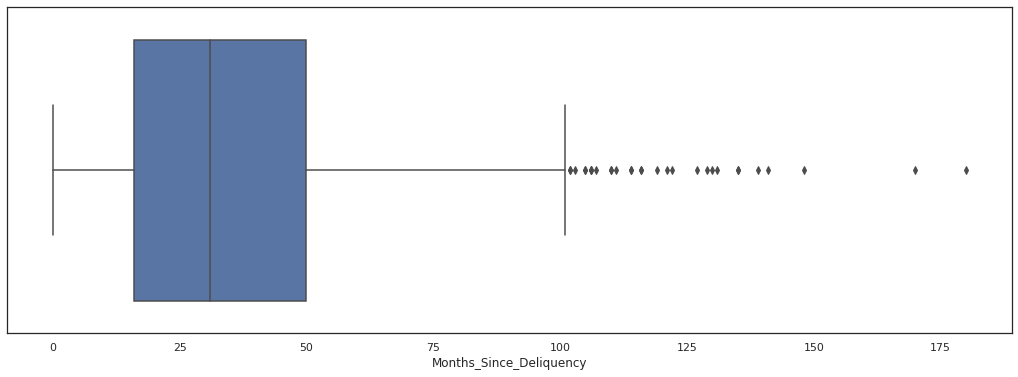

In [95]:
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.boxplot(x=loans['Months_Since_Deliquency'])

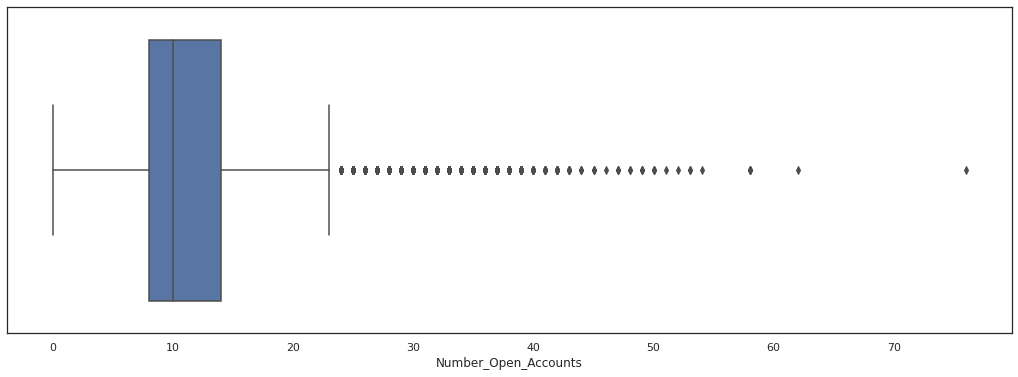

In [96]:
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.boxplot(x=loans['Number_Open_Accounts'])

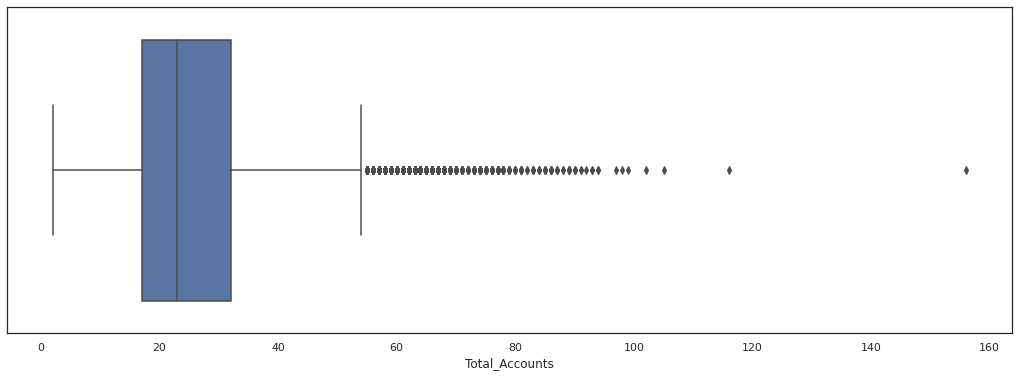

In [97]:
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.boxplot(x=loans['Total_Accounts'])

> In our interger columns we have outliers in all columns apart from loan amount requested

## <font color=”green”>Cleaning our Dataset  </font>

**Loan amount requested**

In [6]:
loans['Loan_Amount_Requested'] = loans['Loan_Amount_Requested'].str.replace(',', '')
loans['Loan_Amount_Requested'] = loans['Loan_Amount_Requested'].astype('int')

> Loan_Amount_Requested had commas and had to be replaced

**Lenght employed**

In [7]:
le = loans['Length_Employed']

In [8]:
le.unique()

array(['< 1 year', '4 years', '7 years', '8 years', '2 years',
       '10+ years', '1 year', nan, '6 years', '9 years', '3 years',
       '5 years'], dtype=object)

In [9]:
le[le=='< 1 year'] = '0 years'
le.fillna('0 years', inplace=True)

> We combined those who did not give their time employed and those who had 0 to 1 year of employment time

In [10]:
lef = le.str.replace('years','').str.replace('year','').str.replace('<','').str.replace('+','').str.replace(' ','')

> We then removed the strings in the column leaving only the integers

In [11]:
loans['Length_Employed']=lef.astype('int')

**Home owner**

In [12]:
own = loans['Home_Owner']
own.value_counts()

Mortgage    70345
Rent        56031
Own         12525
Other          49
None           10
Name: Home_Owner, dtype: int64

In [13]:
loans['Home_Owner']=own.fillna('Other')

**Annual_Income**

In [14]:
loans['Annual_Income'].mean()

73331.15943386468

In [15]:
def fix(dfr):
  na=dfr['Annual_Income'][dfr['Annual_Income'].isna()==True].index
  # df=pd.concat([train,test])
  for ind in na:
    # ind=dfr['Age'].index
    purpose     =dfr['Purpose_Of_Loan'].iloc[ind]
    debt_income =dfr['Debt_To_Income'].iloc[ind]

    mn=(dfr['Annual_Income'][(dfr['Purpose_Of_Loan']==purpose) & 
                             ((dfr['Debt_To_Income'] <= (debt_income+1))& 
                              (dfr['Debt_To_Income'] >= (debt_income-1)))
                             ]).mean()
    # print(mn)
    dfr['Annual_Income'].iloc[ind]=mn
fix(loans)

> We imputed the null values with customers with the average income from customers with a similar purpose of loan and within -1,+1 of the customers debt to income.

**Deliquency**

In [16]:
loans['Months_Since_Deliquency'].isna().sum()

88379

In [17]:
# Creating the classifications of the customers from 
def status(x):
  if x<=3.0:
    return 'Normal'
  elif ((x>3.0) & (x<=12.0)):
    return 'Medium risk'
  elif x>12.0:
    return 'High risk'
  else:
    return 'Low risk'

In [18]:
loans['deliquency_level']=loans.apply(lambda x: status(x['Months_Since_Deliquency']),axis=1)

In [19]:
loans.drop('Months_Since_Deliquency',axis=1,inplace=True)
loans['deliquency_level'].value_counts()

Low risk       88379
High risk      61548
Medium risk    12210
Normal          2172
Name: deliquency_level, dtype: int64

In [20]:
loans.dropna(inplace=True)

In [21]:
loans.isna().sum()

Loan_ID                  0
Loan_Amount_Requested    0
Length_Employed          0
Home_Owner               0
Annual_Income            0
Income_Verified          0
Purpose_Of_Loan          0
Debt_To_Income           0
Inquiries_Last_6Mo       0
Number_Open_Accounts     0
Total_Accounts           0
Gender                   0
Interest_Rate            0
deliquency_level         0
dtype: int64

#### <font color=”green”>Exploratory Analysis </font>

##### <font color="yellow">Univariate Analysis  </font>

In [119]:
loans.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,deliquency_level
0,10000001,7000,0,Rent,68000.000000,not verified,car,18.37,0,9,14,Female,1,Low risk
1,10000002,30000,4,Mortgage,75909.659968,VERIFIED - income,debt_consolidation,14.93,0,12,24,Female,3,High risk
2,10000003,24725,7,Mortgage,75566.400000,VERIFIED - income source,debt_consolidation,15.88,0,12,16,Male,3,Low risk
3,10000004,16000,0,Other,56160.000000,VERIFIED - income source,debt_consolidation,14.34,3,16,22,Male,3,Low risk
4,10000005,17000,8,Own,96000.000000,VERIFIED - income source,debt_consolidation,22.17,1,19,30,Female,1,Low risk


In [22]:
# Frequency distribution table for purpose of loan attribute
loans['Purpose_Of_Loan'].value_counts()

debt_consolidation    97101
credit_card           36684
home_improvement       9269
other                  8346
major_purchase         3435
small_business         2392
car                    1885
medical                1541
moving                  974
vacation                835
wedding                 828
house                   773
renewable_energy        122
educational             121
Name: Purpose_Of_Loan, dtype: int64

> From the value counts the loans were purposely for debt consolidation.

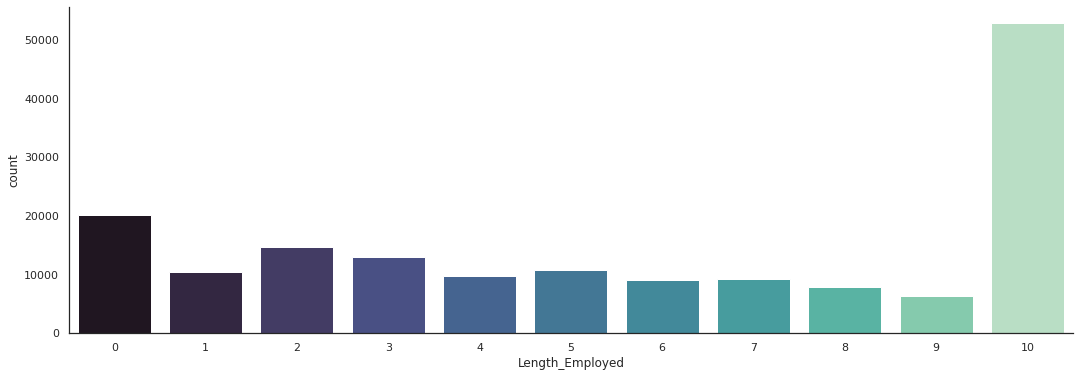

In [23]:
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.countplot(x='Length_Employed',data=loans,palette='mako')
sns.despine()

* 10+ years were the highest to request for a loan

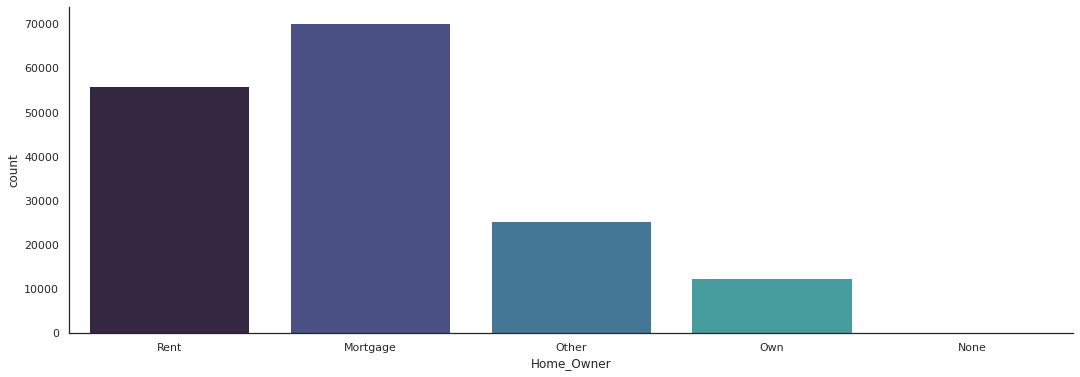

In [122]:
# Plotting bar chart to show home ownership
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.countplot(x='Home_Owner',data=loans,palette='mako')
sns.despine()

* The Mortgage home owners are the highest and owned home_owners lowest

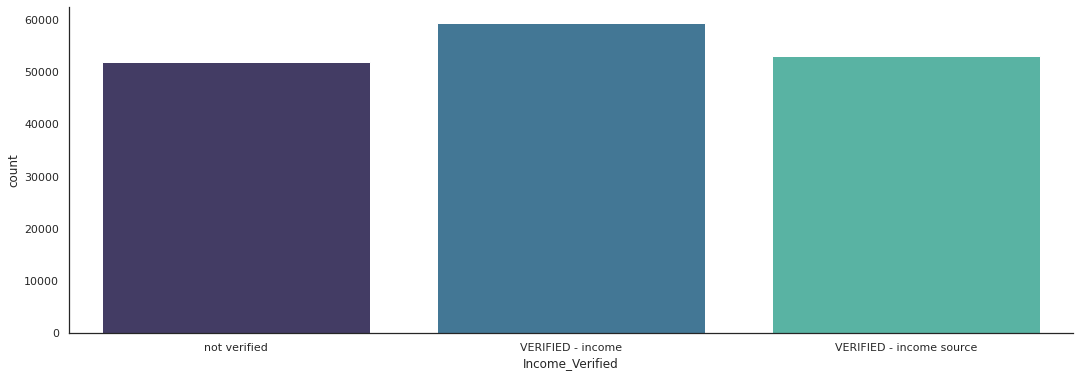

In [123]:
# Plotting bar chart to show income verified 
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.countplot(x='Income_Verified',data=loans,palette='mako')
sns.despine()

 On verified income individuals the ones who have Verified income have the highest count and not verified lowest count.

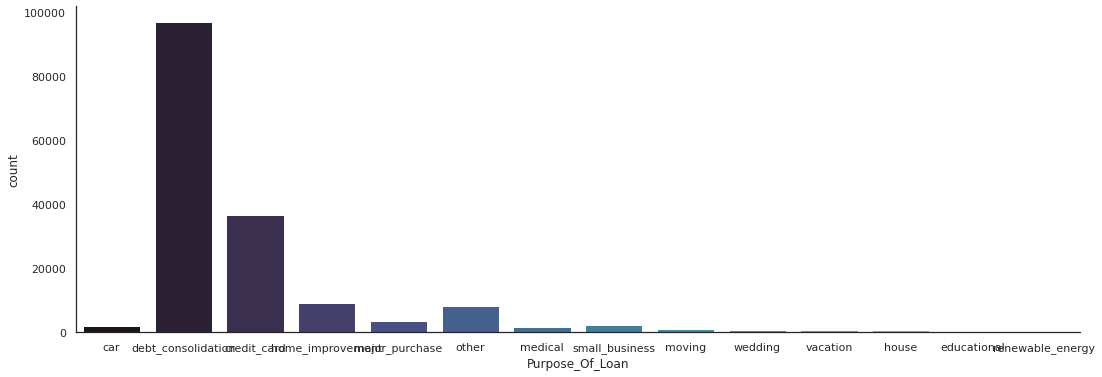

In [124]:
# Plotting bar chart to show purpose of loan 
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.countplot(x='Purpose_Of_Loan',data=loans,palette='mako')
sns.despine()

Debt_consolidatiion had the highest count refering that loans taken were purposely for debt consolidation.

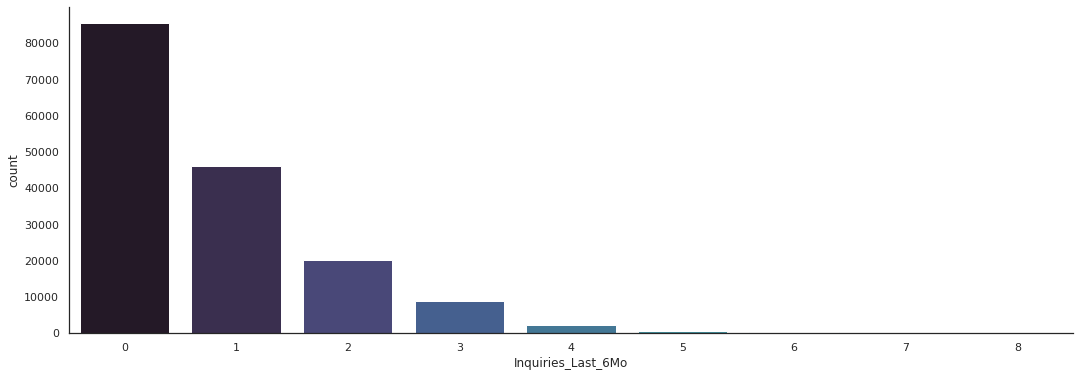

In [125]:
# Plotting bar chart to show inquiries in last 6 months. 
sns.set(rc={'figure.figsize':(18,6)},style="white")
sns.countplot(x='Inquiries_Last_6Mo',data=loans,palette='mako')
sns.despine()

Most of the enquiries are done during the initial months, decreasing towards the sixth month.

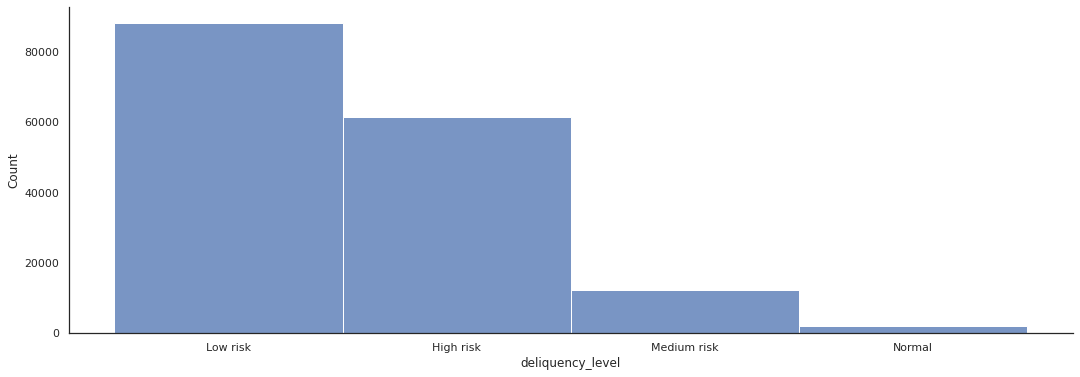

In [126]:
sns.histplot(x='deliquency_level',data=loans,palette='mako')
sns.despine()

> **description deliquency**<- In a financial sense, delinquency occurs as soon as a borrower misses a payment on a loan. In contrast, default occurs when a borrower fails to repay the loan as specified in the original contractMost are low risk clients are highest and normal client who do not default are lowest

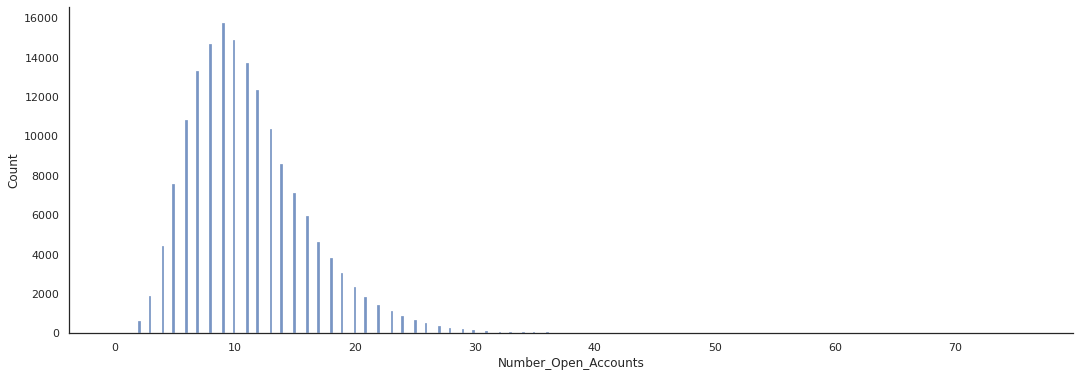

In [127]:
sns.histplot(x='Number_Open_Accounts',data=loans,palette='mako')
sns.despine()

> Most clients have more than one accounts opened as we can see above its right-skewed.With most having more than 10.

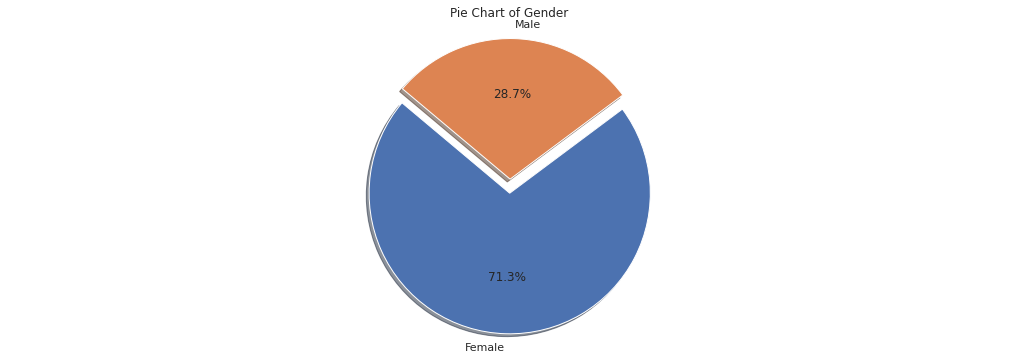

In [128]:
#Gender Distribution
Gender = loans['Gender'].value_counts()
labels = loans.Gender.unique()
explode = (0.1, 0) 
plt.pie(Gender, labels = labels, explode = explode,autopct = '%1.1f%%', shadow = True, startangle = 140)
plt.axis('equal')
plt.title('Pie Chart of Gender')
plt.show()

> Males have the highest percentage in loan applications with a 71 percent higher than females with percentage of 29 percent.

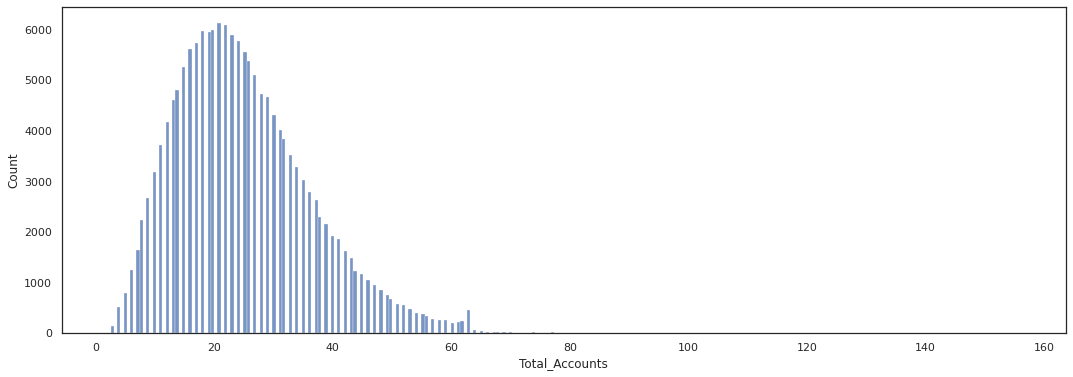

In [129]:
# Plotting histogram for Total Accounts 
sns.histplot(loans['Total_Accounts'])

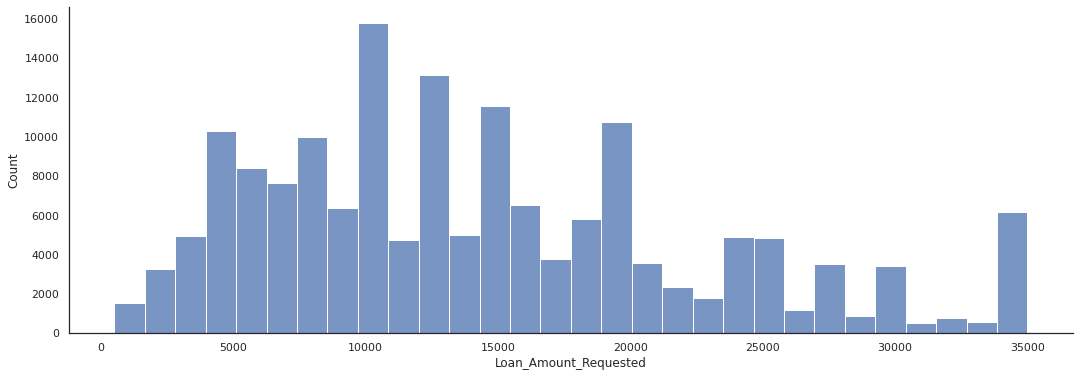

In [131]:
# Plotting bar chart to show Loan amount requested
sns.histplot(x='Loan_Amount_Requested',data=loans,palette='mako',bins=30)
sns.despine()

The most loan Amount value requested is 10000

##### <font color="yellow">Measures of central Tendecy  </font>

In [132]:
# mean, mode and median Annual income

print('Mean Annual income is ' + str(loans.Annual_Income.mean()))
print('Median Annual income is ' + str(loans.Annual_Income.median()))
print('Mode Annual income is ' + str(loans.Annual_Income.mode()))

Mean Annual income is 73323.47145556637
Median Annual income is 65243.82725987755
Mode Annual income is 0    60000.0
dtype: float64


In [133]:
# mean, mode and median Total accounts

print('Mean  Total accounts is ' + str(loans.Total_Accounts.mean()))
print('Median Total accounts is ' + str(loans.Total_Accounts.median()))
print('Mode  Total accounts is ' + str(loans.Total_Accounts.mode()))

Mean  Total accounts is 25.067648168660913
Median Total accounts is 23.0
Mode  Total accounts is 0    21
dtype: int64


In [134]:
#checking for measures of central tendency of relevant columns
loans = loans[['Loan_Amount_Requested','Annual_Income','Inquiries_Last_6Mo','Number_Open_Accounts', 'Total_Accounts']]
loans.describe()

,Loan_Amount_Requested,Annual_Income,Inquiries_Last_6Mo,Number_Open_Accounts,Total_Accounts
count,164306.000000,1.643060e+05,164306.000000,164306.000000,164306.000000
mean,14349.478412,7.332347e+04,0.781712,11.193827,25.067648
std,8281.866087,5.577796e+04,1.034751,4.991837,11.583161
min,500.000000,4.000000e+03,0.000000,0.000000,2.000000
25%,8000.000000,4.850000e+04,0.000000,8.000000,17.000000
50%,12075.000000,6.524383e+04,0.000000,10.000000,23.000000
75%,20000.000000,8.500000e+04,1.000000,14.000000,32.000000
max,35000.000000,7.500000e+06,8.000000,76.000000,156.000000


### <font color=”green”>Bivariate Analysis</font>>
<font color="yellow">Comparison Graphs </font>

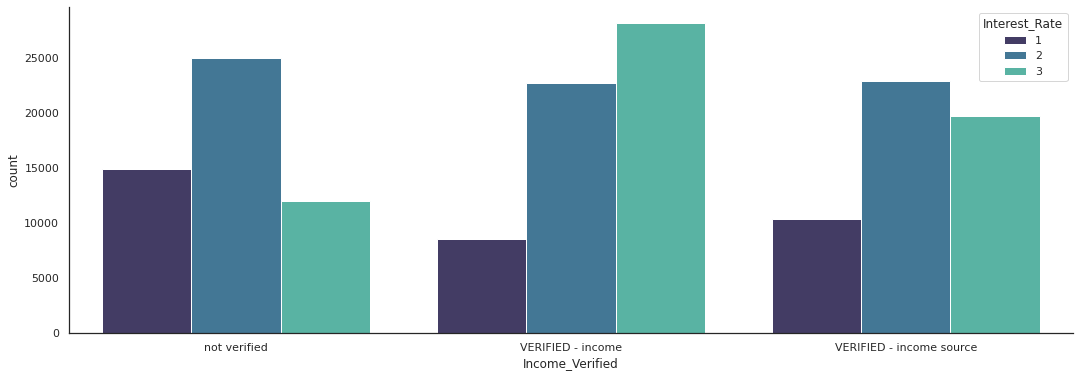

In [24]:
sns.countplot(x='Income_Verified',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * Clients without vefified sources of income dont have a very high interest rate 
> * Clients with verified sources of high have high interest rates 
> * clients with verified income source dont have a high interest rates

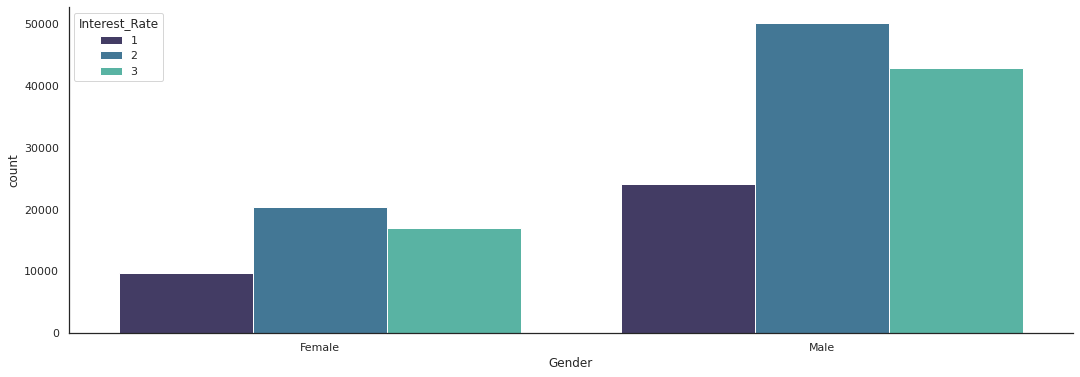

In [25]:
sns.countplot(x='Gender',data=loans,hue='Interest_Rate',palette='mako')
sns.despine()

> * For all interes high,low,and medium male clients have the highest interest rates

> * 

In [ ]:
waaaa

### <font color=”green”>Multivariate Analysis</font>

#### <font color="yellow">3-D comparison plots </font>

## Feature engineering

> Label enoding will bring a bad bias:


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
def labels_(name):
  x = loans[name]
  xx = le.fit_transform(x)
  y = pd.DataFrame({'org':x,'new':xx})
  print(y.value_counts())
  
labels_('Income_Verified')

> Label encoding would imply those not verified have the highest importance while those that have their income is verified.

> Leaving the 

In [ ]:
# Ploting the bivariate summaries and recording observations
#
sns.pairplot(loans)
plt.show()

In [ ]:
# Plotting the Pearson correlation coefficient among variables
plt.figure(figsize=(20, 20))
sns.heatmap(loans.corr(),annot=True)
plt.show()

In [ ]:

# scatter plot to check correlation of Gender and Interest Rate
#
plt.figure(figsize = (14,6))
sns.regplot(loans['Gender'],loans['Interest_Rate'])
plt.ylabel('Gender')
plt.xlabel('Interest_Rate')
plt.title('Correlation between Interest Rate and Gender')
plt.show()

# Xtra

In [ ]:
loans